# Spams detection
## *PROJECT IN MACHINE LEARNING FOR NLP*



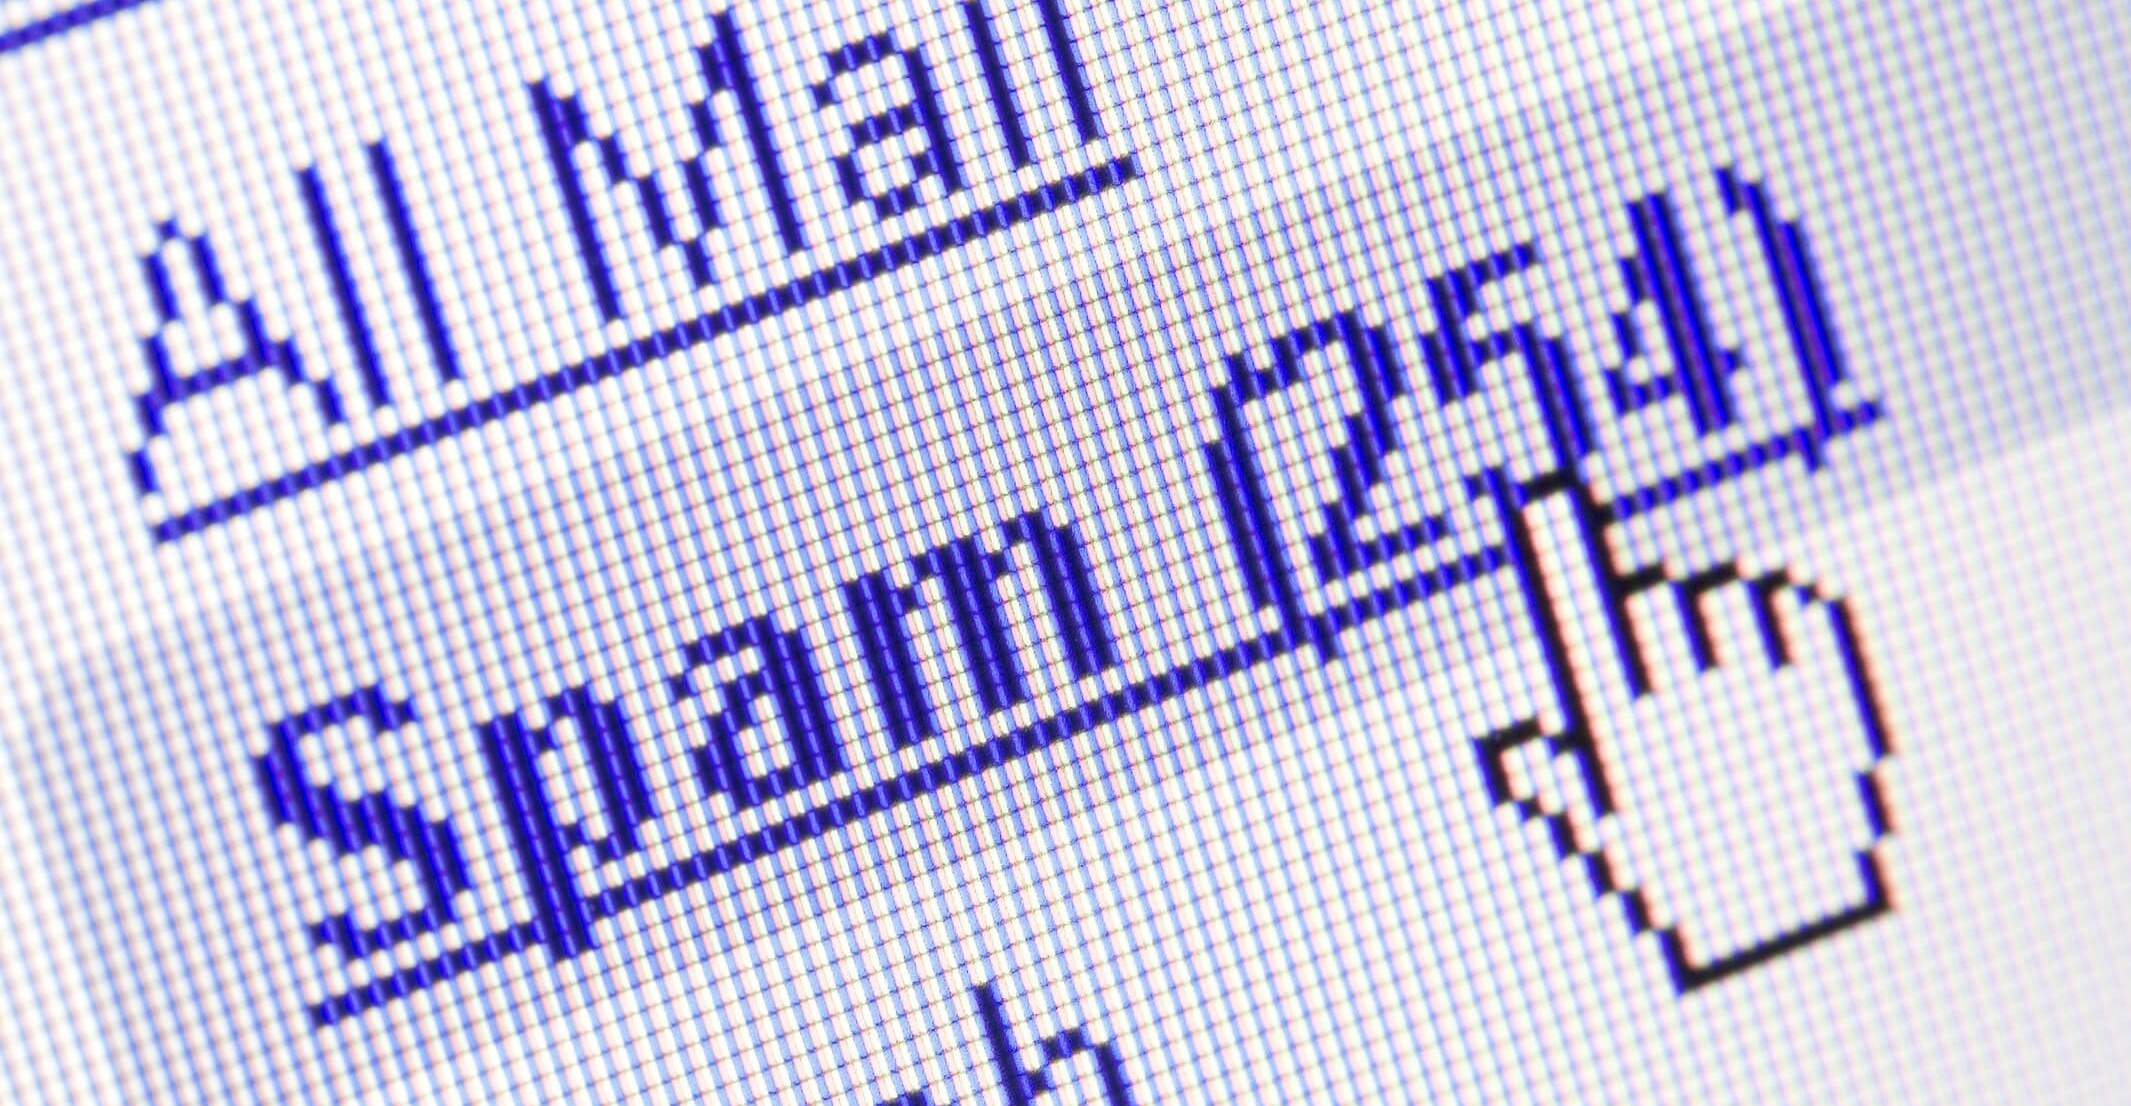

# Introduction

The spam issue knows a huge interest since the last 20 years. It could represent more then 72% of the whole mailing or messaging trafic. The intrusive side apart, it can contain contain viruses or malware, which is why it is interesting and essential to detect it. In this project, we try to create a performing model and to explore more advanced models in the detection of spams.

The dataset we used is from the spam detection research used in several papers (https://www.dt.fee.unicamp.br/~tiago/smsspamcollection/).

This dataset holds a collection of SMS in english and their classification as a spam or a ham. We try to answer the following questions : *How can we treat text messages efficiently ? What preprocessing can we do ? What models can we use for this type of problem ? How do we evaluate our models ? What vectorizer makes the best scores ? What variables can we add to the dataset ? What is the most performing model ?*

We start by the importation of the dataset, the exploration and preprocessing. We then train a first simple model SVM. After that, we try to create new variables from the text messages and train a Random Forest with these new variables and the SMS. The last trained models developped in this notebook are a RNN and a LSTM. Finally, for all of our models we do a quantitative evaluation and for our last model we do a qualitative evaluation.

## Import the dataset

In [ ]:
# Importation of the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Importation of the dataset from the GitHub
url = 'https://raw.githubusercontent.com/maximeberillon/Spam_Detection/main/data/spam.csv'
df = pd.read_csv(url, encoding='latin-1')

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Data exploration

We start by deleting the columns that aren't usefull in the database and renaming those of interest : *sms* and *target*

In [ ]:
df.dropna(how="any", inplace=True, axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.columns = ['target', 'sms']
df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.describe()

,target,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Analysis of the label *target* :

In [ ]:
df.groupby('target').describe()

sms                                                               
       count unique                                                top freq
target                                                                     
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

In [ ]:
df[df.target=='ham'].describe()

,target,sms
count,4825,4825
unique,1,4516
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
df[df.target=='spam'].describe()

,target,sms
count,747,747
unique,1,653
top,spam,Please call our customer service representativ...
freq,747,4


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


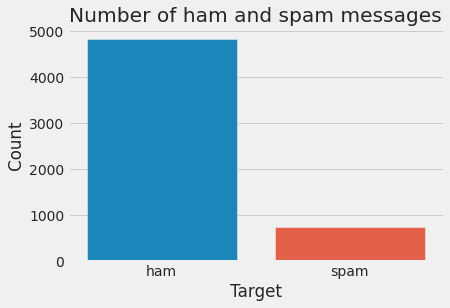

In [ ]:
sns.countplot(df["target"])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Number of ham and spam messages')
plt.show()

We see that a big majority of the messages are **hams**. We have a problem of imbalanced classes that we need to take into account in our models and in the choice of the evaluation metrics. This is a classic case for problems of anomaly detection.

## Preprocessing

We create a new variable *label* that takes the following values :
- 0 if *target* = ham
- 1 if *target* = spam

In [ ]:
df['label'] = df.target.map({'ham':0, 'spam':1})
df.head()

,target,sms,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


We delete the punctuation and stopwords from the messages.

In [ ]:
#For a given text, it removes the punctuation, stopwords and returns a list
def preprocess(sms):
    
    STOPWORDS = stopwords.words('english') + ['u', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']

    #we keep only characters that aren't punctuations
    not_punc = [car for car in sms if car not in string.punctuation]

    #We join the characters to remake the text
    not_punc = ''.join(not_punc)
    
    #We delete stopwords
    return ' '.join([word for word in not_punc.split() if word.lower() not in STOPWORDS])

We create a new column of clean messages (which are SMS cleaned by the preprocess function) called *'clean_msg'*

In [ ]:
df['clean_msg'] = df.sms.apply(preprocess)
df.head()

,target,sms,label,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,Nah think goes usf lives around though


Let's see what are the most frequent words in ham then in spams :

In [ ]:
words = df[df.target=='ham'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(10))

[('get', 303), ('ltgt', 276), ('ok', 272), ('go', 247), ('ill', 236), ('know', 232), ('got', 231), ('like', 229), ('call', 229), ('come', 224)]


In [ ]:
words = df[df.target=='spam'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(10))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83)]


We see that the most frequent words in spams were predictible with the words "call" and "free".

We split in Train (70%) and Test (30%) the cleaned messages and the label : (We keep the same sets for almost every model to compare the scores)

In [ ]:
Y = df['label'].values
X = df['clean_msg'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# First model : SVM

The first model we develop is a SVM classifier. The algorithm creates a line or a hyperplane which separates the data into classes and so separates "spams" from "hams". To obtain the right variables we need to vectorize the words and thus the SMS. For that we use two embeddings :
- First, we train a Word2Vec on our own data with package Gensim (https://code.google.com/archive/p/word2vec/) ;
- Then, we use a pre-trained Word2Vec model to compare the performances, here GloVe is a pre-trained model on 6B words from Wikipedia (https://nlp.stanford.edu/projects/glove/)

## Personalized embedding

In [ ]:
# Importation of the necessary packages
import gensim
from gensim.models import Word2Vec

In [ ]:
# Preparation of the training set
data = [[word for word in sms.split()] for sms in X_train]
data[247]

['Someone',
 'know',
 'asked',
 'dating',
 'service',
 'contact',
 'Cant',
 'Guess',
 'CALL',
 '09058091854',
 'revealed',
 'PO',
 'BOX385',
 'M6',
 '6WU']

In [ ]:
# Definition of Word2Vec
w2v = gensim.models.Word2Vec(data,        # train
                             size=150,    # Dimension of the embedding
                             window=3,    # Number of words in window
                             min_count=2, # Minimal number of occurences
                             workers=10,  # Number of workers
                             iter=500,    # Number of iterations
                             sg=1)        # Skip-gram

In [ ]:
#The 10 closest words to ill
w2v.wv.most_similar('ill', topn=10)

[('Ah', 0.45387211441993713),
 ('responcewhat', 0.4424649178981781),
 ('messageno', 0.41482749581336975),
 ('Looks', 0.4122214913368225),
 ('Another', 0.4086056351661682),
 ('prob', 0.40467798709869385),
 ('truffles', 0.3984760642051697),
 ('happend', 0.3966969847679138),
 ('forgiven', 0.38568443059921265),
 ('Kkwhen', 0.3713345229625702)]

In [ ]:
#We create a function that transforms our training and testing set with this embedding
def transform(X, model, vocab_size):
    return np.stack([np.mean([model[word] for word in sms if word in model] or
                    [np.zeros(vocab_size)], axis=0) for sms in X])

In [ ]:
X_train1 = transform(X_train, w2v, 150)
X_test1 = transform(X_test, w2v, 150)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
#We define and train a SVM classifier
from sklearn.svm import SVC

svc = SVC(class_weight='balanced') # imbalanced classes
svc.fit(X_train1, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Quantitative evaluation :
For the quantitative evaluation, we will focus on the F1-score on our testing set since our classes are strongly imbalanced (the accuracy wouldn't be relevant and the F1-score is a mean between the precision and the recall).

In [ ]:
Y_pred_train = svc.predict(X_train1)
Y_pred = svc.predict(X_test1)
print("Accuracy: test/train", accuracy_score(Y_test, Y_pred), accuracy_score(Y_train, Y_pred_train))
print("F1 Score: test/train", f1_score(Y_test, Y_pred), f1_score(Y_train, Y_pred_train))
print("Precision: test/train", precision_score(Y_test, Y_pred), precision_score(Y_train, Y_pred_train))
print("Recall: test/train", recall_score(Y_test, Y_pred), recall_score(Y_train, Y_pred_train))

Accuracy: test/train 0.9545454545454546 0.9620512820512821
F1 Score: test/train 0.8403361344537815 0.8687943262411348
Precision: test/train 0.7782101167315175 0.8166666666666667
Recall: test/train 0.91324200913242 0.928030303030303


We see that the accuracy is good which is not a surprise since the imbalance of the casses. However, the F1-score isn't bad. The model is relatively simple and can be used as a *baseline* for the following.

## Pre-trained embedding

In [ ]:
# Importation of the model
! wget http://nlp.stanford.edu/data/glove.6B.zip
! unzip glove.6B.zip

--2021-04-23 11:50:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-23 11:50:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-23 11:50:01--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# gloveto a model Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

glove_filename='glove.6B.100d.txt'
word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_filename, word2vec_output_file)

w2v_g = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
# We transform our train and test with this embedding 
X_train2 = transform(X_train, w2v_g, 100)
X_test2 = transform(X_test, w2v_g, 100)

In [ ]:
# We train the same model
svc = SVC(class_weight='balanced')
svc.fit(X_train2, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
Y_pred_train = svc.predict(X_train2)
Y_pred = svc.predict(X_test2)
print("Accuracy : test/train", accuracy_score(Y_test, Y_pred), accuracy_score(Y_train, Y_pred_train))
print("F1 Score : test/train", f1_score(Y_test, Y_pred), f1_score(Y_train, Y_pred_train))
print("Precision : test/train", precision_score(Y_test, Y_pred), precision_score(Y_train, Y_pred_train))
print("Recall : test/train", recall_score(Y_test, Y_pred), recall_score(Y_train, Y_pred_train))

Accuracy : test/train 0.9688995215311005 0.9623076923076923
F1 Score : test/train 0.8823529411764706 0.8595988538681948
Precision : test/train 0.874439461883408 0.8670520231213873
Recall : test/train 0.8904109589041096 0.8522727272727273


We see a clear improvement of the scores, especially of the F1-score which goes from 0.84 to 0.88.

# Second model : Random Forest

We try here a new model : Random Forest. We compare two functions which allow to tranform the text in matrices :

- CountVetorizer : converts a collection of texts in a matrix of counts of token
- TfidfTransformer : equivalent to CountVectorizer followed by TfidfTransformer. The latter transforms a matrix of counts in a representation tf-idf (the tf-idf can evaluate the importance of a word contained in a document, relatively to a collection)

### Random Forest with CountVectorizer

In [ ]:
all_text = np.concatenate([X_train, X_test])

word_vectorizer = CountVectorizer(stop_words = 'english', analyzer='word')
word_vectorizer.fit(all_text)

X_train3 = word_vectorizer.transform(X_train)
X_test3 = word_vectorizer.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight="balanced", max_depth=10)
model.fit(X_train3, Y_train)
Y_pred = model.predict(X_test3)

#### Quantitative evaluation :

In [ ]:
Y_pred_train = model.predict(X_train3)
print("Accuracy : test/train", accuracy_score(Y_test, Y_pred), accuracy_score(Y_train, Y_pred_train))
print("F1 Score : test/train", f1_score(Y_test, Y_pred), f1_score(Y_train, Y_pred_train))
print("Precision : test/train", precision_score(Y_test, Y_pred), precision_score(Y_train, Y_pred_train))
print("Recall : test/train", recall_score(Y_test, Y_pred), recall_score(Y_train, Y_pred_train))

Accuracy: test/train 0.965311004784689 0.9733333333333334
F1 Score: 0.8481675392670157 0.8909853249475892
Precision: 0.9938650306748467 0.9976525821596244
Recall: 0.7397260273972602 0.8049242424242424


The F1-score is already very good, let's see the scores with TfidfVectorizer while keeping the same parameters.

### Random Forest with TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer()
vector_output = vect.fit(all_text)

X_train4 = vector_output.transform(X_train)
X_test4 = vector_output.transform(X_test)

In [ ]:
model = RandomForestClassifier(class_weight="balanced", max_depth=10)
model.fit(X_train4, Y_train)
Y_pred = model.predict(X_test4)

#### Quantitative evaluation :

In [ ]:
Y_pred_train = model.predict(X_train4)
print("Accuracy : test/train", accuracy_score(Y_test, Y_pred), accuracy_score(Y_train, Y_pred_train))
print("F1 Score : test/train", f1_score(Y_test, Y_pred), f1_score(Y_train, Y_pred_train))
print("Precision : test/train", precision_score(Y_test, Y_pred), precision_score(Y_train, Y_pred_train))
print("Recall : test/train", recall_score(Y_test, Y_pred), recall_score(Y_train, Y_pred_train))

Accuracy: test/train 0.9683014354066986 0.9776923076923076
F1 Score: 0.8623376623376623 0.9104016477857879
Precision: 1.0 0.9977426636568849
Recall: 0.7579908675799086 0.8371212121212122


The F1-score is slightly better with TfidfVectorizer.

### Random Forest with new variables

We tried to improve our model by adding text-related variables such as the length of the SMS, the number of punctuation marks, and the presence of long or short numbers in the messages. We visualise for each variable the distribution of ham and spam and observe that these are discriminating variables that should be added to the model. 

We add a column which idicates the length of the message.

In [ ]:
df['len_sms'] = df.sms.apply(len)
df.head()

,target,sms,label,clean_msg,len_sms
0,ham,"Go until jurong point, crazy.. Available only ...",0,Go jurong point crazy Available bugis n great ...,111
1,ham,Ok lar... Joking wif u oni...,0,Ok lar Joking wif oni,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry wkly comp win FA Cup final tkts 21s...,155
3,ham,U dun say so early hor... U c already then say...,0,dun say early hor c already say,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,Nah think goes usf lives around though,61


In [ ]:
# The longest sms
df[df['len_sms'] == df['len_sms'].max()].sms.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

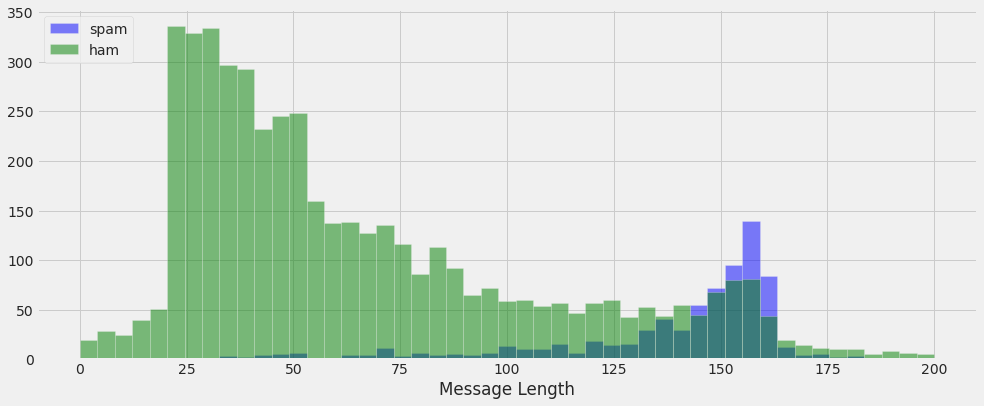

In [ ]:
plt.figure(figsize=(15,6))

bins = np.linspace(0,200,num=50)
plt.hist(df[df['target']=='spam']['len_sms'],bins,alpha=0.5,label='spam', color="blue")
plt.hist(df[df['target']=='ham']['len_sms'],bins,alpha =0.5,label ='ham', color="green")
plt.legend(loc ='upper left')
plt.xlabel("Message Length")
plt.show()

We see that the hams seem to be shorter messages than spams in general. Therefore it would be interesting to add it to our model.

We add a column which indicates the number of punctuation.

In [ ]:
import string
def count_punct (text):
    count = sum([1 for x in text if x in string.punctuation])
    pp = round(100*count/(len(text)-text.count(" ")),3)
    return pp

df['punct'] = df['sms'].apply(lambda x : count_punct(x))

In [ ]:
df.head()

,target,sms,label,clean_msg,len_sms,punct
0,ham,"Go until jurong point, crazy.. Available only ...",0,Go jurong point crazy Available bugis n great ...,111,9.783
1,ham,Ok lar... Joking wif u oni...,0,Ok lar Joking wif oni,29,25.000
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry wkly comp win FA Cup final tkts 21s...,155,4.688
3,ham,U dun say so early hor... U c already then say...,0,dun say early hor c already say,49,15.385
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,Nah think goes usf lives around though,61,4.082


<function matplotlib.pyplot.show>

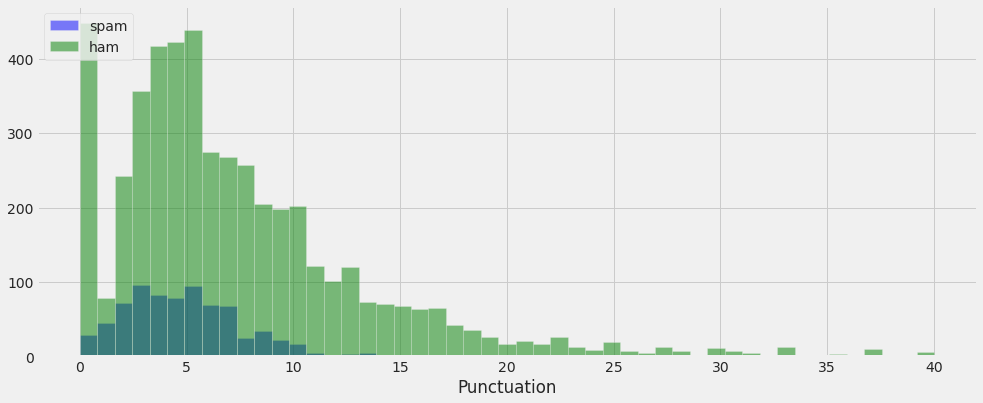

In [ ]:
plt.figure(figsize=(15,6))

bins = np.linspace(0,40,num=50)

plt.hist(df[df['target']=='spam']['punct'],bins, color="blue", label ='spam', alpha=0.5)
plt.hist(df[df['target']=='ham']['punct'],bins, color="green", label='ham', alpha=0.5)
plt.legend(loc ='upper left')
plt.xlabel("Punctuation")
plt.show


It seems like the hams contain more punctuation than the spams but also that a lot of hams have no punctuation at all.

We finally add a variable which indicates the number of  numbers of more then 7 figures in a SMS called "long_number" and another which indicates the number of numbers of 4 to 7 figures called "short_number".

In [ ]:
#long or short numbers

import re 

df['long_number'] = df['sms'].apply(lambda x : len(re.findall('\d{7,}',x))) #plus de 7 chiffres
df['short_number'] = df['sms'].apply(lambda x : len(re.findall('\d{4,6}',x))) #de 4 à 7 chiffres


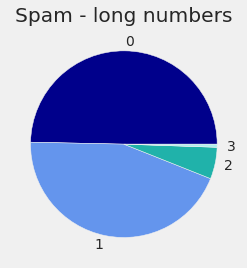

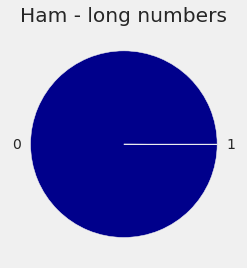

In [ ]:
#long numbers
blue_palette = ['darkblue','cornflowerblue', 'lightseagreen', 'paleturquoise','blue', 'seagreen', 'skyblue', 'lavender']

plt.figure(figsize=(4,4))
plt.pie(df[df['target']=='spam']['long_number'].value_counts(),labels=['0','1','2','3'], 
           colors=blue_palette)
plt.title("Spam - long numbers")
plt.show()


plt.figure(figsize=(4,4))
plt.pie(df[df['target']=='ham']['long_number'].value_counts(),labels=['0','1'], 
           colors=blue_palette)
plt.title("Ham - long numbers")
plt.show()

We see a strong discrimination on long numbers since almost every ham don't contain long numbers while more than half of spams does.

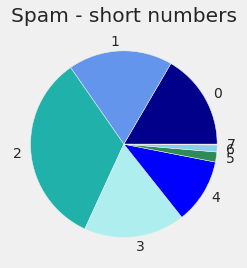

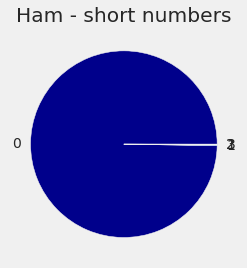

In [ ]:
#short numbers

spam_x = df[df['target']=='spam']['short_number'].value_counts()
spam_x.sort_index(inplace=True)
plt.figure(figsize=(4,4))
plt.pie(spam_x,labels=spam_x.index,startangle=0,
        colors=blue_palette)
plt.title("Spam - short numbers")
plt.show()

ham_x = df[df['target']=='ham']['short_number'].value_counts()
ham_x.sort_index(inplace=True)
plt.figure(figsize=(4,4))
plt.pie(ham_x,labels=ham_x.index, 
        colors=blue_palette)
plt.title("Ham - short numbers")
plt.show()

Once again, the variable short number is interesting since hams contain only a few short numbers compared to spams.

So we add these 4 variables to the vectorized texts with TfidfVectorizer, we split into train and test and we train the random forest with the same parameter as before :

In [ ]:
features = pd.concat([df['len_sms'],df['long_number'],df['short_number'],df['punct'],
                      pd.DataFrame(vector_output.transform(X).toarray())],axis=1)

In [ ]:
X_train5, X_test5, y_train, y_test = train_test_split(features, df["label"], random_state=1)

In [ ]:
model = RandomForestClassifier(class_weight="balanced", max_depth=10)
model.fit(X_train5,y_train)
y_pred = model.predict(X_test5)
y_pred_train = model.predict(X_train5)

#### Quantitative evaluation :

In [ ]:
print("Accuracy : test/train", accuracy_score(y_test, y_pred), accuracy_score(y_train, y_pred_train))
print("F1 Score : test/train", f1_score(y_test, y_pred), f1_score(y_train, y_pred_train))
print("Precision : test/train", precision_score(y_test, y_pred), precision_score(y_train, y_pred_train))
print("Recall : test/train", recall_score(y_test, y_pred), recall_score(y_train, y_pred_train))

Accuracy : test/train 0.9820531227566404 0.985163914812156
F1 Score : test/train 0.9266862170087977 0.9421641791044777
Precision : test/train 0.9813664596273292 1.0
Recall : test/train 0.8777777777777778 0.890652557319224


We see that the F1 score is amazing with this model (which will be the best in terms of scores).

# Third model : Neural Networks

Finally  we  further  increase  the  complexity  ofthe model and use neural networks.  The best forthis type of task are recurrent neural networks. We therefore studied a RNN and then an LSTM.

### RNN

In [ ]:
import torch.nn as nn
import torch

# Definition of the net

class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim1, embedding_dim):
        super(RNN, self).__init__()
        self.hidden_dim1 = hidden_dim1
        self.embeds = nn.Embedding(vocab_size, embedding_dim)
        self.drop2d = nn.Dropout2d(p=0.3)
        self.rnn = nn.RNN(input_size=embedding_dim,
                          hidden_size=hidden_dim1,
                          num_layers=1,
                          batch_first=True)  
        self.lin1 = nn.Linear(hidden_dim1, 1)
        self.drop1 = nn.Dropout(p=0.3)
        self.act1 = nn.Sigmoid()

    def forward(self, sentence, hidden):
        batch_size = sentence.size(0)
        hidden = self.init_hidden(batch_size)
        x = self.embeds(sentence)
        x = self.drop2d(x)
        x, hidden = self.rnn(x, hidden)
        x = self.lin1(x)
        x = self.drop1(x)
        x = self.act1(x)
        return x, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_dim1)

In [ ]:
# We use here keras pre-processing function since they are easier to use
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

max_words = 500     # Number of words in the vocabulary
max_len = 150       # Max length of the sequences

# Pre-processing
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
X_train_tensor = torch.from_numpy(sequences_matrix)

In [ ]:
from torch.optim import Adam

# Parameters of the model
batch_size=128
embedding_dim=100
hidden_dim1=50

# Creation of the model
model = RNN(vocab_size=max_words,
            hidden_dim1=hidden_dim1,
            embedding_dim=embedding_dim)

# Loss and optimization
lr=0.001

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=lr)

print(model)

RNN(
  (embeds): Embedding(500, 100)
  (drop2d): Dropout2d(p=0.3, inplace=False)
  (rnn): RNN(100, 50, batch_first=True)
  (lin1): Linear(in_features=50, out_features=1, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (act1): Sigmoid()
)


We have a quite simple architecture with :
- Embedding layer ;
- Dropout (to avoid overfitting) ;
- RNN layer ;
- Linear layer ;
- Dropout ;
- Sigmoïd activation (binary output).

In [ ]:
n_epochs = 100

loss_history = []

for epoch in range(1, n_epochs + 1):
    
    permutation = torch.randperm(X_train_tensor.size()[0])
    
    for i in range(0, X_train_tensor.size()[0], batch_size):
        optimizer.zero_grad()
        
        indices = permutation[i:i+batch_size]
        
        hidden = model.init_hidden(batch_size)
        
        batch_x, batch_y = X_train_tensor[indices], Y_train[indices]
        
        output, hidden = model(batch_x, hidden)
        
        loss = criterion(output[:, -1, 0], torch.tensor(batch_y).to(torch.float))
        
        loss.backward()
        optimizer.step()
    
    loss_history.append(loss.item())
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/100............. Loss: 0.1751
Epoch: 20/100............. Loss: 0.2694
Epoch: 30/100............. Loss: 0.2680
Epoch: 40/100............. Loss: 0.2336
Epoch: 50/100............. Loss: 0.2908
Epoch: 60/100............. Loss: 0.3019
Epoch: 70/100............. Loss: 0.2912
Epoch: 80/100............. Loss: 0.1987
Epoch: 90/100............. Loss: 0.2173
Epoch: 100/100............. Loss: 0.2194


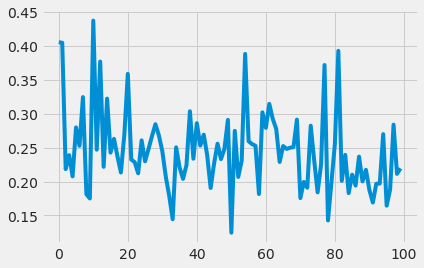

In [ ]:
plt.plot(loss_history)
plt.show()

In [ ]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_test)
sequences = tok.texts_to_sequences(X_test)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
X_test_tensor = torch.from_numpy(sequences_matrix)

In [ ]:
hidden = model.init_hidden(X_test_tensor.size(0))
output, hidden = model(X_test_tensor, hidden)

In [ ]:
def output_binarizer(output):
    vec = output.cpu().detach().numpy()
    return np.array([1 if x > 0.5 else 0 for x in vec])

In [ ]:
Y_pred = output_binarizer(output[:, -1, 0])
hidden = model.init_hidden(X_train_tensor.size(0))
output_train, hidden = model(X_train_tensor, hidden)
Y_pred_train = output_binarizer(output_train[:, -1, 0])

In [ ]:
print("Accuracy: test/train", accuracy_score(Y_test, Y_pred), accuracy_score(Y_train, Y_pred_train))
print("F1 Score: test/train", f1_score(Y_test, Y_pred), f1_score(Y_train, Y_pred_train))
print("Precision: test/train", precision_score(Y_test, Y_pred), precision_score(Y_train, Y_pred_train))
print("Recall: test/train", recall_score(Y_test, Y_pred), recall_score(Y_train, Y_pred_train))

Accuracy: test/train 0.8361244019138756 0.9507692307692308
F1 Score: test/train 0.16969696969696968 0.7823129251700681
Precision: test/train 0.25225225225225223 0.9745762711864406
Recall: test/train 0.1278538812785388 0.6534090909090909


We can see that eventhough the accuracy is great, the F1 score is very bad. We have an overfitting problem. Adding to that a vanishing gradient problem : on sequences of 150 words, the gradient can strongly decrease which reduces the influence of words at the end of the sequences (since the sequences are inverted).

### LSTM

To avoid overfitting, we use a LSTM (Long Short Term Memory).

In [ ]:
import torch.nn as nn
import torch
from torch.autograd import Variable 

# Definition of the net

class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embedding_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=False)
        self.drop = nn.Dropout(p=0.5)
        self.lin = nn.Linear(hidden_dim, 1)
        self.act = nn.Sigmoid()

    def forward(self, sentence):
        h_0 = Variable(torch.zeros(1, sentence.size(0), self.hidden_dim))
        c_0 = Variable(torch.zeros(1, sentence.size(0), self.hidden_dim))
        x = self.embeds(sentence)
        x, (hn, cn) = self.lstm(x, (h_0, c_0))
        x = self.drop(x)
        x = self.lin(x)
        x = self.act(x)
        return x

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

max_words = 500
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
X_train_tensor = torch.from_numpy(sequences_matrix)

In [ ]:
from torch.optim import Adam

# Parameters of the model
batch_size=128
embedding_dim=100
hidden_dim=50

# Creation of the model
model = LSTM(vocab_size=max_words,
             hidden_dim=hidden_dim,
             embedding_dim=embedding_dim)

# Loss and optimisation
lr=0.001

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=lr)

print(model)

LSTM(
  (embeds): Embedding(500, 100)
  (lstm): LSTM(100, 50, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
  (lin): Linear(in_features=50, out_features=1, bias=True)
  (act): Sigmoid()
)


We have a quite similar architecture with :
- Embedding layer ;
- LSTM layer ;
- Dropout (to avoid overfitting) ;
- Linear layer ;
- Sigmoïd activation (binary output).

In [ ]:
n_epochs = 20

loss_history = []

for epoch in range(1, n_epochs + 1):
    
    permutation = torch.randperm(X_train_tensor.size()[0])
    
    for i in range(0, X_train_tensor.size()[0], batch_size):
        optimizer.zero_grad()
        
        indices = permutation[i:i+batch_size]
        
        batch_x, batch_y = X_train_tensor[indices], Y_train[indices]
        
        output = model(batch_x)
        
        loss = criterion(output[:, -1, 0], torch.tensor(batch_y).to(torch.float))
        
        loss.backward()
        optimizer.step()
    
    loss_history.append(loss.item())
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/20............. Loss: 0.0304
Epoch: 20/20............. Loss: 0.0067


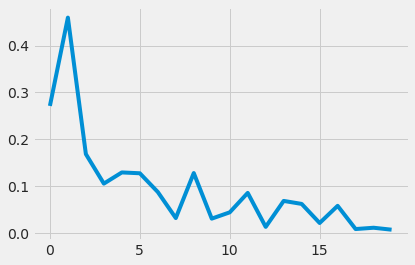

In [ ]:
plt.plot(loss_history)
plt.show()

In [ ]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_test)
sequences = tok.texts_to_sequences(X_test)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
X_test_tensor = torch.from_numpy(sequences_matrix)
output = model(X_test_tensor)

In [ ]:
Y_pred = output_binarizer(output[:, -1, 0])

output_train = model(X_train_tensor)
Y_pred_train = output_binarizer(output_train[:, -1, 0])

In [ ]:
print("Accuracy: test/train", accuracy_score(Y_test, Y_pred), accuracy_score(Y_train, Y_pred_train))
print("F1 Score: test/train", f1_score(Y_test, Y_pred), f1_score(Y_train, Y_pred_train))
print("Precision: test/train", precision_score(Y_test, Y_pred), precision_score(Y_train, Y_pred_train))
print("Recall: test/train", recall_score(Y_test, Y_pred), recall_score(Y_train, Y_pred_train))

Accuracy: test/train 0.847488038277512 0.9956410256410256
F1 Score: test/train 0.22492401215805471 0.983669548511047
Precision: test/train 0.33636363636363636 0.9980506822612085
Recall: test/train 0.1689497716894977 0.9696969696969697


Thanks to this architecture, the F1 score increased (no more vanishing gradient). However we still have a lot of overfitting and we don't get the great performences of the random forest with the new variables.

# Qualitative evaluation :

Let's do the qualitative evaluation of the last model. To do so, we creat a dataframe with the SMS, the class prediction and the true class. We then print a SMS predicted as a spam when it was a ham and a falsely predicted ham.

In [ ]:
df_eval = pd.DataFrame({'sms': X_test,
                        'prediction': Y_pred,
                        'y_true': Y_test})
df_eval.head()

,sms,prediction,y_true
0,Funny fact Nobody teaches volcanoes erupt tsun...,0,0
1,sent scores sophas secondary application schoo...,0,0
2,know someone know fancies Call 09058097218 fin...,1,1
3,promise getting SOON youll text morning let kn...,0,0
4,Congratulations awarded either å£500 CD gift v...,1,1


In [ ]:
df_eval[(df_eval["prediction"]==1)&(df_eval["y_true"]==0)].head(10)

,sms,prediction,y_true
20,Ì call 1010 make sure dat ive woken,1,0
28,Ill reach ard 20 mins ok,1,0
155,Wot wed nite 3 til 9,1,0
184,thk 530 lor dunno get tickets Wat,1,0
267,Din tell jus 420,1,0
321,Hey Congrats 2u2 id luv ive go home,1,0
411,b4 Thursday,1,0
434,Ard 515 like dat,1,0
460,ÌÏ log wat sdryb8i,1,0
571,thk 50 shd ok said plus minus 10 Ì leave line ...,1,0


In [ ]:
#example of a ham predicted as a spam
df_eval.loc[571, 'sms']

'thk 50 shd ok said plus minus 10 Ì leave line paragraphs'

In [ ]:
df_eval[(df_eval["prediction"]==0)&(df_eval["y_true"]==1)].head(10)

,sms,prediction,y_true
61,Buy Space Invaders chance win orig Arcade Game...,0,1
167,XXXMobileMovieClub use credit click WAP link n...,0,1
221,tddnewsletteremc1couk games TheDailyDraw Dear ...,0,1
272,important customer service announcement PREMIER,0,1
448,Email AlertFrom Jeri StewartSize 2KBSubject Lo...,0,1
522,Hello darling today would love chat tell look ...,0,1
652,thesmszonecom lets send free anonymous masked ...,0,1
691,Ever thought living good life perfect partner ...,0,1
860,Hello Orange 1 months free access games news s...,0,1
991,Welcome Select O2 service added benefits call ...,0,1


In [ ]:
#example of a spam predicted as a ham
df_eval.loc[991, 'sms']

'Welcome Select O2 service added benefits call specially trained advisors FREE mobile dialling 402'

We see that our last model is not efficient enough.

# Conclusion :

To conclude, the aim of this project being to explore several methods, we have, through an SVM, a Random Forest, an RNN and an LSTM, tried to predict if an SMS was a spam or a ham. We observed that the best model in terms of performance is the Random Forest with TfidfVectorizer and the addition of discriminating variables. It would have been interesting to try other Deep Learning architectures to improve the scores of our latest models and avoid overfitting.